# Suy diễn nhân quả với package dowhy

## Bs. Lê Ngọc Khả Nhi

Bài thực hành này nhằm trình diễn các tính năng của package dowhy (Microsoft 2018-2019) hỗ trợ suy diễn nhân quả theo quy trình của Judea Pearl (Pearlian inference). Trong bài ta mô phỏng một thí nghiệm can thiệp điều trị dưới ảnh hưởng của 3 backdoor confounders, 2 instrumental variables và 2 effect modifiers, với giả định hiệu ứng có quan hệ tuyến tính với can thiệp.

Bài thực hành sử dụng version mới nhất của dowhy: https://github.com/microsoft/dowhy

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml

In [3]:
dowhy.__version__

'0.2a1'

Đầu tiên, ta sử dụng method datasets.linear_dataset() của dowhy để tạo ra một dữ liệu mô phỏng thí nghiệm can thiệp gồm 1000 quan sát, hiệu quả can thiệp có giá trị giả định = 5, can thiệp là biến định lượng, kết cục là biến định lượng và 7 đại lượng gây nhiễu khác:

In [4]:
data = dowhy.datasets.linear_dataset(beta = 5, 
                                     num_common_causes=3, 
                                     num_samples=1000,
                                     num_instruments=2,
                                     num_effect_modifiers=2,
                                     num_treatments=1,
                                     treatment_is_binary=False)

object data là một dictionary với cấu trúc như sau:

In [10]:
data.keys()

dict_keys(['df', 'treatment_name', 'outcome_name', 'common_causes_names', 'instrument_names', 'effect_modifier_names', 'dot_graph', 'gml_graph', 'ate'])

Dữ liệu được lưu trữ trong key = 'df'

In [5]:
data['df']

,X0,X1,Z0,Z1,W0,W1,W2,v0,y
0,1.020111,-0.604980,1.0,0.093337,0.618502,0.418473,-1.022106,4.479322,17.992602
1,-0.559637,1.558117,1.0,0.438352,-0.949961,0.827142,-2.141993,-2.505089,-24.059794
2,0.590112,-0.373138,1.0,0.305241,-0.015106,2.291211,-0.467805,6.114868,29.316684
3,1.671617,-1.191096,0.0,0.654352,-1.345824,0.826297,1.495399,1.856470,6.353836
4,-0.330756,0.652579,1.0,0.624209,-1.455045,-0.695776,0.313056,2.089018,9.911869
...,...,...,...,...,...,...,...,...,...
995,1.380453,2.042374,0.0,0.828509,1.465430,1.354351,-1.852967,5.028453,50.165983
996,-0.604313,-1.451283,1.0,0.892910,1.233636,1.143017,0.204280,9.407605,21.427224
997,1.342995,0.316189,0.0,0.389429,0.963490,1.725950,-1.581821,4.615727,29.527407
998,-0.031269,1.435775,1.0,0.602860,-0.044779,-0.874825,0.507464,5.755853,45.407115


Trong thí nghiệm này, biến y đại diện cho kết quả can thiệp (Outcome), hay kết cục của nghiên cứu, y được khảo sát như một biến định lượng liên tục. Thí dụ trong thực tế: 1 biomarker hay đại lượng sinh lý bệnh học nào đó (huyết áp,...)

In [7]:
data['outcome_name']

'y'

Trong thí nghiệm, ta áp dụng một can thiệp định lượng (thí dụ: liều, cường độ điều trị), được đo bằng một đại lượng liên tục v0. Thí dụ trong thực tế: Cường độ tập thể dục, liều thuốc...

In [6]:
data['treatment_name']

['v0']

Theo giả thuyết đặt ra, v0 chịu tác động từ 3 biến W0,W1,W2 trước khi ảnh hưởng lên kết cục y; 3 biến này cũng góp phần làm thay đổi y, do đó chúng được gọi là "Common causes" hay "Measurable/observed confounders". Thí dụ trong thực tế: Tuổi, Độ nặng của bệnh lý, ... 

In [52]:
data['common_causes_names']

['W0', 'W1', 'W2']

Ngoài ra, có 2 biến Z0,Z1 độc lập với y nhưng có tác động lên v0, thuật ngữ suy diễn nhân quả gọi Z0,Z1 là những biến công cụ (Instrumental variables).

In [53]:
data['instrument_names']

['Z0', 'Z1']

Cuối cùng, có 2 biến X0 và X1 gây ảnh hưởng lên hiệu quả điều trị một cách độc lập, thuật ngữ gọi chúng là "Effect modifiers"

In [19]:
data['effect_modifier_names']

['X0', 'X1']

Thăm dò trực quan đặc tính phân phối và liên hệ giữa các biến trong dữ liệu:

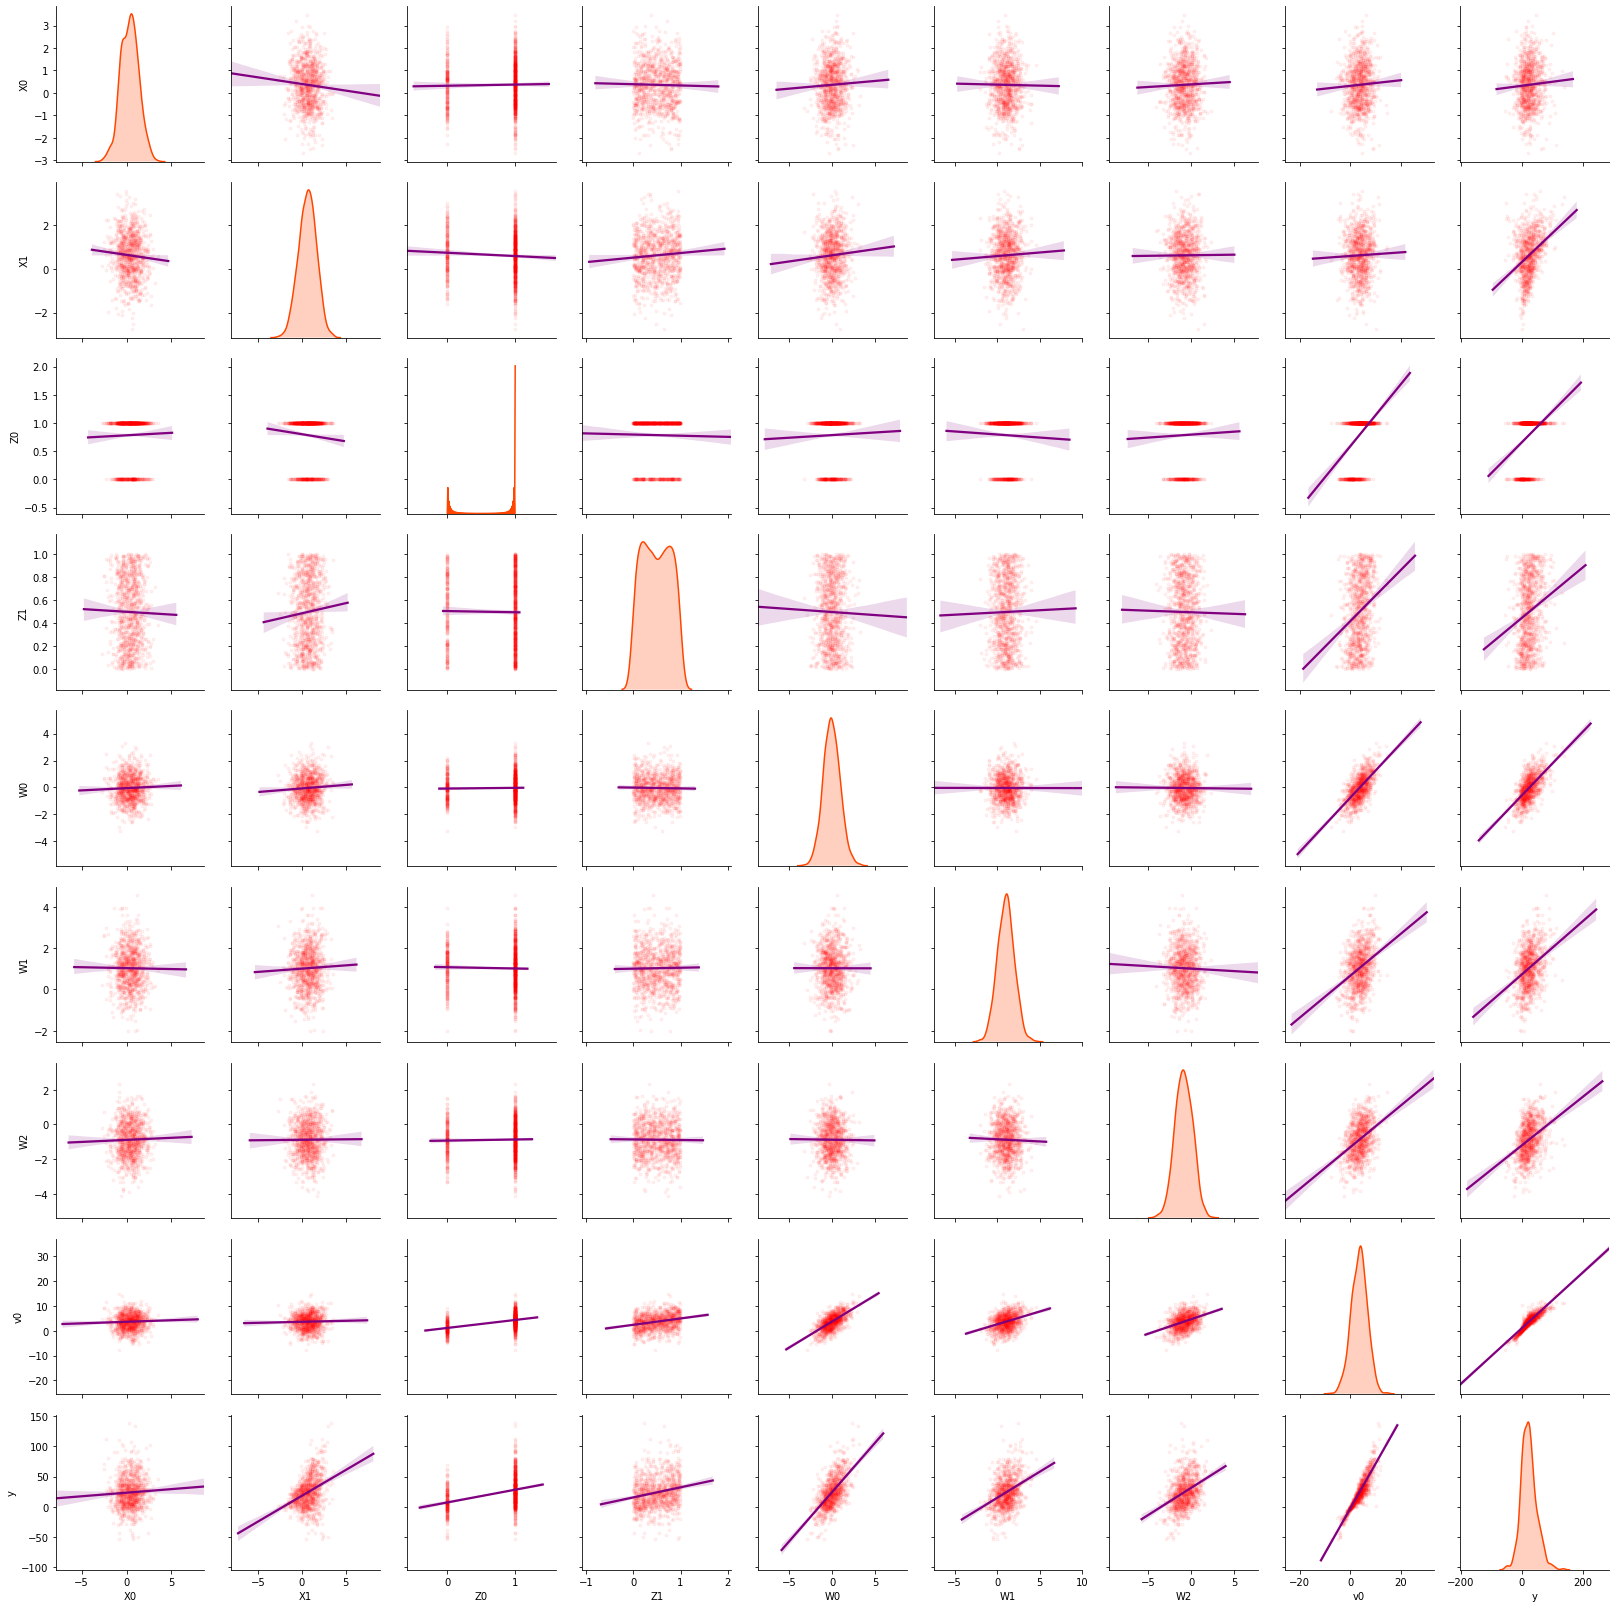

In [43]:
import seaborn as sns

g = sns.pairplot(data['df'], 
                 diag_kind="kde", 
                 kind="reg",markers=".",
                 plot_kws= {'color': 'purple', 'scatter_kws':{'color':'red','alpha':0.05}},
                 diag_kws= {'color': 'orangered', 'shade': True})

Trong dictionary data, dowhy cũng dựng sẵn 2 sơ đồ nhân quả tương ứng với dữ liệu này, dưới 2 định dạng dot_graph và gml_graph. Ta có thể truy nhập nội dung của 2 mô hình mạng này, bản chất chúng là string, lưu cú pháp mô tả sơ đồ, ta có thể học cú pháp này để dựng thủ công những mạng lưới khác tùy thích. 

Sơ đồ nhân quả hay mạng lưới nhân quả là yếu tố bắt buộc phải có trong quy trình suy diễn nhân quả theo Judea Pearl (Pearlian inference). Sơ đồ này dựa trên lý luận, giả thuyết và kiến thức của người làm nghiên cứu về quan hệ tương tác giữa các đại lượng (biến) trong thí nghiệm.

In [20]:
data['dot_graph']

'digraph { U[label="Unobserved Confounders"]; U->y;v0->y; U->v0;W0-> v0; W1-> v0; W2-> v0; W3-> v0;Z0-> v0; Z1-> v0;W0-> y; W1-> y; W2-> y; W3-> y;X0-> y; X1-> y;}'

In [48]:
data['gml_graph']

'graph[directed 1node[ id "y" label "y"]node[ id "Unobserved Confounders" label "Unobserved Confounders"]edge[source "Unobserved Confounders" target "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"]node[ id "Z0" label "Z0"] node[ id "Z1" label "Z1"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[source "Unobserved Confounders" target "v0"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"] edge[ source "W3" target "v0"]edge[ source "Z0" target "v0"] edge[ source "Z1" target "v0"]edge[ source "W0" target "y"] edge[ source "W1" target "y"] edge[ source "W2" target "y"] edge[ source "W3" target "y"]node[ id "X0" label "X0"] edge[ source "X0" target "y"] node[ id "X1" label "X1"] edge[ source "X1" target "y"]]'

# Bước 1: Lập mô hình nhân quả

Quy trình suy diễn bắt đầu bằng việc dựng một mô hình nhân quả, bằng hàm CausalModel. 
Ta cần khai báo: dữ liệu, 2 thành phần chính như treatment (biến can thiệp), outcome (biến kết cục). Ngoài ra, vai trò của những biến còn lại có thể được khai báo theo 2 cách: dùng sơ đồ nhân quả, hay chỉ đích danh vai trò của từng nhóm biến. Ở đây ta đã có sơ đồ (graph) nên dùng nó luôn cho nhanh:

In [55]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], 
                    outcome=data["outcome_name"],
                    graph=data["gml_graph"])

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


Xem sơ đồ mô hình nhân quả:

INFO:dowhy.causal_graph:Using Matplotlib for plotting


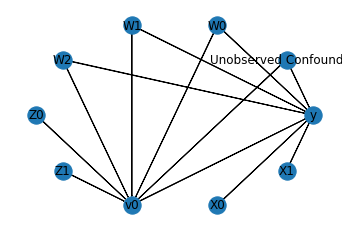

In [72]:
model.view_model()

# Bước 2: Xác định các trị số cần ước lượng (estimand)

Bước thứ 2 trong quy trình suy diễn nhân quả theo Pearl là xác định các 'estimands' (những ẩn số cần được 'estimate').

method identify_effect() của dowhy thực hiện việc này một cách nhanh chóng bằng cách sử dụng 'do calculus' dựa theo sơ đồ ta đã mô tả.

Theo kết quả này, có 2 estimands, thuộc loại 'backdoor' (tương ứng W0,W1,W2 là những biến tác động lên cả treatment v0 và outcome y) và biến công cụ (instrument variable) được đại diện bằng U, tương ứng với hiệu ứng của Z0 và Z1 tác động lên outcome y một cách gián tiếp qua Treatment v0 

In [73]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)

print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W2', 'W0', 'Unobserved Confounders', 'W1']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                          
───(Expectation(y|W2,W0,W1))
dv₀                         
Estimand assumption 1, Unconfoundedness: If U→v0 and U→y then P(y|v0,W2,W0,W1,U) = P(y|v0,W2,W0,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v0, Z1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v0, then ¬(Z1,Z0→y)



In [74]:
identified_estimand.estimands

{'backdoor': {'estimand': Derivative(Expectation(y|W2,W0,W1), v0),
  'assumptions': {'Unconfoundedness': 'If U→v0 and U→y then P(y|v0,W2,W0,W1,U) = P(y|v0,W2,W0,W1)'}},
 'iv': {'estimand': Expectation(Derivative(y, Z1)/Derivative(v0, Z1)),
  'assumptions': {'As-if-random': 'If U→→y then ¬(U →→Z1,Z0)',
   'Exclusion': 'If we remove {Z1,Z0}→v0, then ¬(Z1,Z0→y)'}}}

In [75]:
identified_estimand.estimand_type

'ate'

In [42]:
identified_estimand.backdoor_variables

['W3', 'W1', 'W2', 'W0']

# Bước 3: Ước lượng averaged treatment effect

Ta đã gần đạt đến mục tiêu: ước lượng được hiệu ứng thực sự của can thiệp điều trị v0 lên y, bằng cách dùng method estimate_effect().

Dowhy hỗ trợ rất nhiều phương pháp suy diễn nhân quả, ta sẽ lần lượt thử 2 cách tiêu biểu, đơn giản nhất là mô hình tuyến tính + control backdoor:

## Cách 1: Linear regression:

In [76]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                        control_value=0,
                                        treatment_value=1,
                                        test_significance=True,
                                        target_units='ate',
                                       )

print(linear_estimate)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W0+W1


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                          
───(Expectation(y|W2,W0,W1))
dv₀                         
Estimand assumption 1, Unconfoundedness: If U→v0 and U→y then P(y|v0,W2,W0,W1,U) = P(y|v0,W2,W0,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v0, Z1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v0, then ¬(Z1,Z0→y)

## Realized estimand
b: y~v0+W2+W0+W1
## Estimate
Value: 4.999999999999996

## Statistical Significance
p-value: <0.001



In [77]:
linear_estimate.value

Kết quả cho ra chính xác so với giả định ban đầu (causal effect beta = 5)

## Cách 2: Sử dụng algorithm Double Machine learning CATE Estimator:

Đây là phương pháp ước lượng mới được Microsoft phát triển qua package econml, bằng cách áp dụng 2 mô hình Machine learning riêng biệt : model_t ước lượng treatment, và model_y ước lượng outcome dựa vào các biến trong dữ liệu, sau đó dùng một mô hình Machine learning thứ 3 (model_final) để ước lượng hiệu ứng nhân quả dựa vào residuals của 2 mô hình trên.

Điều thú vị đó là econml cho phép người dùng tùy nghi sử dụng các algorithm Machine learning từ scikitlearn cho mỗi mô hình. Trong thí dụ này, ta dùng ElasticnetCV cho final_model và RandomForest cho model_t, model_y

In [83]:
from sklearn.preprocessing import PolynomialFeatures as PolyF
from sklearn.linear_model import ElasticNetCV as EnetCV
from sklearn.ensemble import RandomForestRegressor as RFReg

dml_estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.econml.dml.DMLCateEstimator",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y': RFReg(),
                                                                   'model_t': RFReg(),
                                                              "model_final": EnetCV(), 
                                                              'featurizer':PolyF(degree=1, include_bias=True),},
                                               "fit_params":{'inference': 'bootstrap',}
                                                   }
                                    )
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W0+W1
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                          
───(Expectation(y|W2,W0,W1))
dv₀                         
Estimand assumption 1, Unconfoundedness: If U→v0 and U→y then P(y|v0,W2,W0,W1,U) = P(y|v0,W2,W0,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v0, Z1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v0, then ¬(Z1,Z0→y)

## Realized estimand
b: y~v0+W2+W0+W1
## Estimate
Value: 6.217810676159844



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


In [139]:
print(f'Hiệu ứng điều trị :{np.mean(dml_estimate.cate_estimates)}')

Hiệu ứng điều trị :6.217810676159844


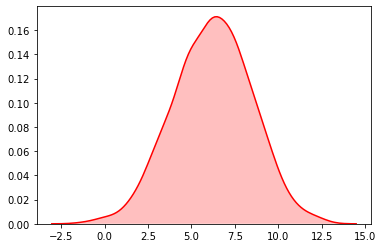

In [128]:
g = sns.kdeplot(dml_estimate.cate_estimates.reshape(1000,), shade =True, color = "red")

In [134]:
print('Hiệu ứng thực =', data['ate'])

Hiệu ứng thực = 6.396761170872422


# Kết luận: 

Thư viện dowhy và econml là những công cụ rất tiện lợi do Microsoft phát triển, cho phép thực hành lý thuyết suy diễn nhân quả của Judea Pearl với ngôn ngữ Python. Các bạn bác sĩ nên tìm hiểu về những framework mới này nhằm áp dụng vào nghiên cứu y học lâm sàng.